# The Pulsar Star Problem: Pulsar Star Classification Using Two Signal Preprocessing Techniques

By, Arnab Das, Emily Black, Adam Mitha, Matthew Parnian


In [ ]:
install.packages("tidymodels")
install.packages("kknn")
install.packages("themis")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘foreach’, ‘GPfit’, ‘dials’, ‘infer’, ‘modeldata’, ‘parsnip’, ‘tune’, ‘workflows’, ‘workflowsets’, ‘yardstick’




In [ ]:
library(tidyverse)
library(dplyr)
library(kknn)
library(tidymodels)
library(themis)

## Introduction

Neutron stars are high-density celestial bodies caused by a large mass star collapsing on itself due to its own gravity (Goldberger, 2019). Pulsars are a classification of neutron stars which “pulse” or emit electromagnetic radiation periodically because of its high rotational velocity and strong magnetic fields. Telescopes on Earth can measure the continuous pulses of radio frequencies emitted by pulsars (Rodriguez, 2019). Identifying pulsar signals among interference and noise can be difficult, so machine learning can be used to predict target pulsars based on their recorded metrics.

Because the pulsar produces periodic pulsation signals they are often too weak to detect (Liu, 2017). Preprocessing this time series by folding the data with respect to the rotational period of the pulsar, yields a unique and distinguishable pulsar fingerprint referred to as an integrated pulse profile. The profile shape has an increased signal quality and form, and through long term observations are considered generally stable, as opposed to the highly variable single pulses (Liu, 2017).

However, before signals reach earth, they must pass through interstellar medium (ISM). This medium consists of everything that could possibly exist between a pulsar and the Earth (Liu, 2017). There are several major effects on pulsar radio signals, namely dispersion, scintillation, and scattering (Grootjans 2016), but for the purpose of this report only dispersion will be explored. The pulsar signal can be considered a plane wave whose frequency depends on interactions between ionized components of the ISM (Grootjans, 2016).The frequency dependence of these waves causes higher frequency waves to arrive earlier and lower frequency waves to arrive later, by an amount defined by a dispersion measure (DM) (Liu, 2017). The DM of any frequency is also proportional to the distance of the pulsar. All these factors result in the broadening and reducing the peak values for the frequency distribution curve of a pulsar. When a sufficient amount of dispersion is present in the signal, a signal-to-noise ratio (SNR) preprocessing (taking into consideration antenna aperture and other properties relevant to noise) must be applied to further analyze the pulsar curve by fitting the data (Grootjans, 2016). By applying this filter, a DM-SNR curve can be produced which has removed dispersion distortions in pulse shapes.

 In the “Predicted Pulsar Star” Kaggle dataset, an integrated profile and a DM-SNR curve is considered. These two preprocessed measurements have tabulated results for the following statistics: mean, standard deviation, excess kurtosis, and skewness of these measurements. Excess kurtosis describes the tails on a normal distribution to measure the probability of events occurring outside of the normal range, unlike skewness which refers to the symmetry of a normal distribution. In our dataset, our target_class has been identified by binary classification, where a value of 1 represents a pulsar, and the value of 0 represents a non-pulsar.


In this project we will explore how a star’s integrated and DM-SNR profiles affect the accuracy of K-Nearest Neighbors classification models based on these two profiles. The question we aim to answer is: can DM-SNR curve and integrated profile measurements predict pulsar stars? If so, which preprocessing technique yields the most accurate model? We hypothesize that the model built using DM-SNR curve measurements will yield the most accurate model, because it takes into account the noise of space, which is a common source of error when star signals are recorded.




## Methods and Results

We'll start by downloading the data set and reading it into a dataframe.

In [ ]:
# Load training data from Kaggle
unzip("pulsar_data_train.csv.zip")
pulsar_data <- read_csv("pulsar_data_train.csv")

Warning message in unzip("pulsar_data_train.csv.zip"):
“error -1 in extracting from zip file”
Rows: 12271 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): Mean of the integrated profile, Standard deviation of the integrate...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [ ]:
# Update column names to be more 'code-friendly'
colnames(pulsar_data) <- c("mean_integrated", "stdev_integrated", "kurtosis_integrated", "skew_integrated", "mean_DMSNR", "stdev_DMSNR", "kurtosis_DMSNR", "skew_DMSNR", "class")
# Covert target class to factor
pulsar_data <- pulsar_data %>% mutate(class=as_factor(class))

In [ ]:
# Load testing file from Kaggle
unzip("pulsar_data_test.csv.zip")
pulsar_test_unclass <- read_csv("pulsar_data_test.csv")

Warning message in unzip("pulsar_data_test.csv.zip"):
“error -1 in extracting from zip file”
Rows: 5370 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (8): Mean of the integrated profile, Standard deviation of the integrate...
lgl (1): target_class

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [ ]:
#Update column names to be more 'code friendly'
colnames(pulsar_test_unclass) <- c("mean_integrated", "stdev_integrated", "kurtosis_integrated", "skew_integrated", "mean_DMSNR", "stdev_DMSNR", "kurtosis_DMSNR", "skew_DMSNR", "class")
summary(pulsar_test_unclass)

 mean_integrated  stdev_integrated kurtosis_integrated skew_integrated  
 Min.   :  6.18   Min.   :24.79    Min.   :-1.8760     Min.   :-1.7647  
 1st Qu.:101.04   1st Qu.:42.41    1st Qu.: 0.0306     1st Qu.:-0.1896  
 Median :114.76   Median :47.03    Median : 0.2273     Median : 0.1865  
 Mean   :111.17   Mean   :46.62    Mean   : 0.4837     Mean   : 1.7513  
 3rd Qu.:127.02   3rd Qu.:51.13    3rd Qu.: 0.4751     3rd Qu.: 0.9188  
 Max.   :192.62   Max.   :98.78    Max.   : 7.6084     Max.   :65.3860  
                                   NA's   :767                          
   mean_DMSNR        stdev_DMSNR     kurtosis_DMSNR     skew_DMSNR      
 Min.   :  0.2132   Min.   :  7.37   Min.   :-2.722   Min.   :  -1.965  
 1st Qu.:  1.9565   1st Qu.: 14.56   1st Qu.: 5.700   1st Qu.:  33.817  
 Median :  2.8307   Median : 18.55   Median : 8.384   Median :  81.392  
 Mean   : 12.4736   Mean   : 26.43   Mean   : 8.234   Mean   : 102.869  
 3rd Qu.:  5.5903   3rd Qu.: 28.68   3rd Qu.:10.632

We can see that the test dataset doesn't have any target classes.
So, this dataset is not useful to us in training/testing our model, and we will need to split the training dataset.

We will split the pulsar data set into training and testing sets. The testing set will not be touched until the model is ready for evaluation. We are splitting the data into 75% training and 25% testing because the dataset is sufficiently large (~9,000 observations) that leaving 25% of the data for testing is enough to accurately assess the performance of our model.

In [ ]:
# Split into training and testing set
set.seed(111)
# Determine how many rows have missing values.
num_rows_missing_values <- sum(apply(pulsar_data, 1, anyNA))
# Number of rows with missing values: 3183
# For our predictions down the road, we need to remove rows with NA values from the test set
pulsar_omit_na <- na.omit(pulsar_data) #this is so our KNN model will run properly later
pulsar_split <- initial_split(pulsar_omit_na, prop = 0.75, strata = class)
pulsar_train <- training(pulsar_split)
pulsar_test <- testing(pulsar_split)


### Exploratory Analysis


In [ ]:
head(pulsar_train)

mean_integrated,stdev_integrated,kurtosis_integrated,skew_integrated,mean_DMSNR,stdev_DMSNR,kurtosis_DMSNR,skew_DMSNR,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
121.15625,48.37297,0.37548466,-0.01316549,3.168896,18.39937,7.449874,65.15930,0
76.96875,36.17556,0.71289786,3.38871856,2.399666,17.57100,9.414652,102.72297,0
130.58594,53.22953,0.13340829,-0.29724164,2.743311,22.36255,8.508364,74.03132,0
109.40625,55.91252,0.56510595,0.05624666,2.797659,19.49653,9.443282,97.37458,0
95.00781,40.21981,0.34757810,1.15316438,2.770067,18.21774,7.851205,70.80194,0
130.08594,46.40262,-0.04658483,-0.03446839,5.050167,27.99748,6.059849,38.15479,0


Table 1: Raw pulsar data (training set)

There are eight predictive variables and one target variable. The predictors are composed of two groups of readings: the integrated profile and the DMSNR profile. Each group has the same four measurements: mean, standard deviation, kurtosis, and skew. We will use descriptive statistics and visualizations to explore the differences between the two profiles in order to determine which predictors will be most useful for our model.

In [ ]:
# Calculate the number and percentage of observations that are pulsar stars.
num_obs <- nrow(pulsar_train)
class_dist <- pulsar_train %>% group_by(class) %>% summarize(n=n(), percentage=n()/num_obs*100)
class_dist
#class 0 (non-pulsar stars): 90.8% of the data
#class 1 (pulsar stars): 9.2% of the data

class,n,percentage
<fct>,<int>,<dbl>
0,6206,91.050469
1,610,8.949531


Table 2: Frequencies of target classes

In [ ]:
# We will also calculate the mean of the predictors in the dataset.
#mean of the predictors
predictor_means <- pulsar_train %>% select(-class) %>% map_df(~mean(., na.rm=TRUE))
predictor_means
#now, let's omit rows with NA values.
pulsar_train <- na.omit(pulsar_train)

mean_integrated,stdev_integrated,kurtosis_integrated,skew_integrated,mean_DMSNR,stdev_DMSNR,kurtosis_DMSNR,skew_DMSNR
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
111.4294,46.5161,0.4677782,1.740679,12.60573,26.15276,8.407471,107.9382


Table 3: Mean of predictor variables

The predictors' scale varies significantly, as evidenced by the calculated means. Since the k-nn classification algorithm is particularly sensitive to predictors with larger values, we need to scale and center the data before building the model. This ensures that predictors with larger values (e.g. mean of the integrated profile) don't have a disproportionate effect on the classification model.

### Data Visualization
Visualizing the data can give us an idea of the distribution of predictors, and may give us an indication of which predictors will be most useful in the creation of our model.

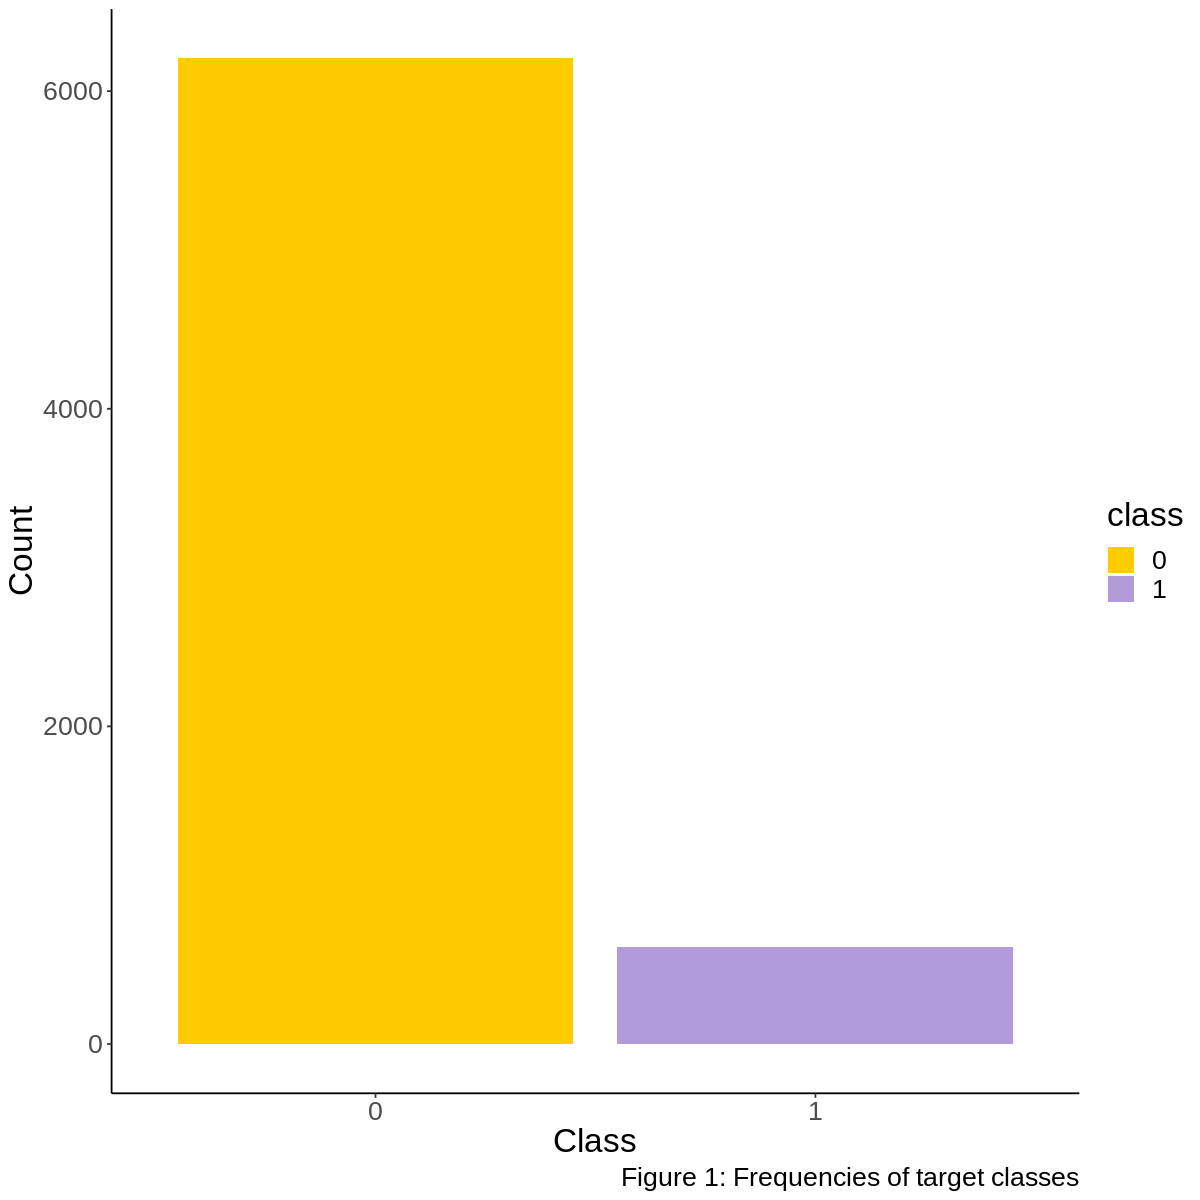

In [ ]:
# To visualize the distribution of pulsar vs non-pulsar stars, we can use a bar chart.
class_plot <- subset(class_dist, !is.na(class)) %>% ggplot(aes(x=class, y=n, fill=class)) +
  geom_bar(stat="identity") +
      scale_fill_manual(values=c("#FFCC00", "#b19cd9"))+
  ylab("Count") +
  xlab("Class")+
  labs(caption="Figure 1: Frequencies of target classes") +
  theme_classic()+
  theme(text=element_text(size=20))
class_plot

There are significantly more observations in the non-pulsar (0) than pulsar (1) class. Imbalanced data can result in the model inappropriately preferring the more common class. In order to account for this imbalance, we will need to upsample the pulsar class to produce an accurate model (see methods for more details on how this is done).

To visualize the relationship between predictors and the target class, we can create violin plots of each predictor variable stratified by target class. Unlike boxplots, violin plots allow us to visualize both the distribution and density of the underlying data. This additional detail about the data will help with our intuition when it comes to selecting predictors for our model.

Using those plots, we can see which predictors vary most between the two target classes, and between integrated and DM-SNR.

The data needs to be tidied before the violin plots can be created. Specifically, we will be moving the values of each of the predictors from their own columns into key-value pairs using the gather function.

In [ ]:
tidy_stars <- pulsar_train %>%
gather(key=profile, value=value, mean_integrated, stdev_integrated, kurtosis_integrated, skew_integrated,
mean_DMSNR, stdev_DMSNR, kurtosis_DMSNR, skew_DMSNR)
head(tidy_stars)

class,profile,value
<fct>,<chr>,<dbl>
0,mean_integrated,121.15625
0,mean_integrated,76.96875
0,mean_integrated,130.58594
0,mean_integrated,109.40625
0,mean_integrated,95.00781
0,mean_integrated,130.08594


Table 4: Tidied pulsar data

Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


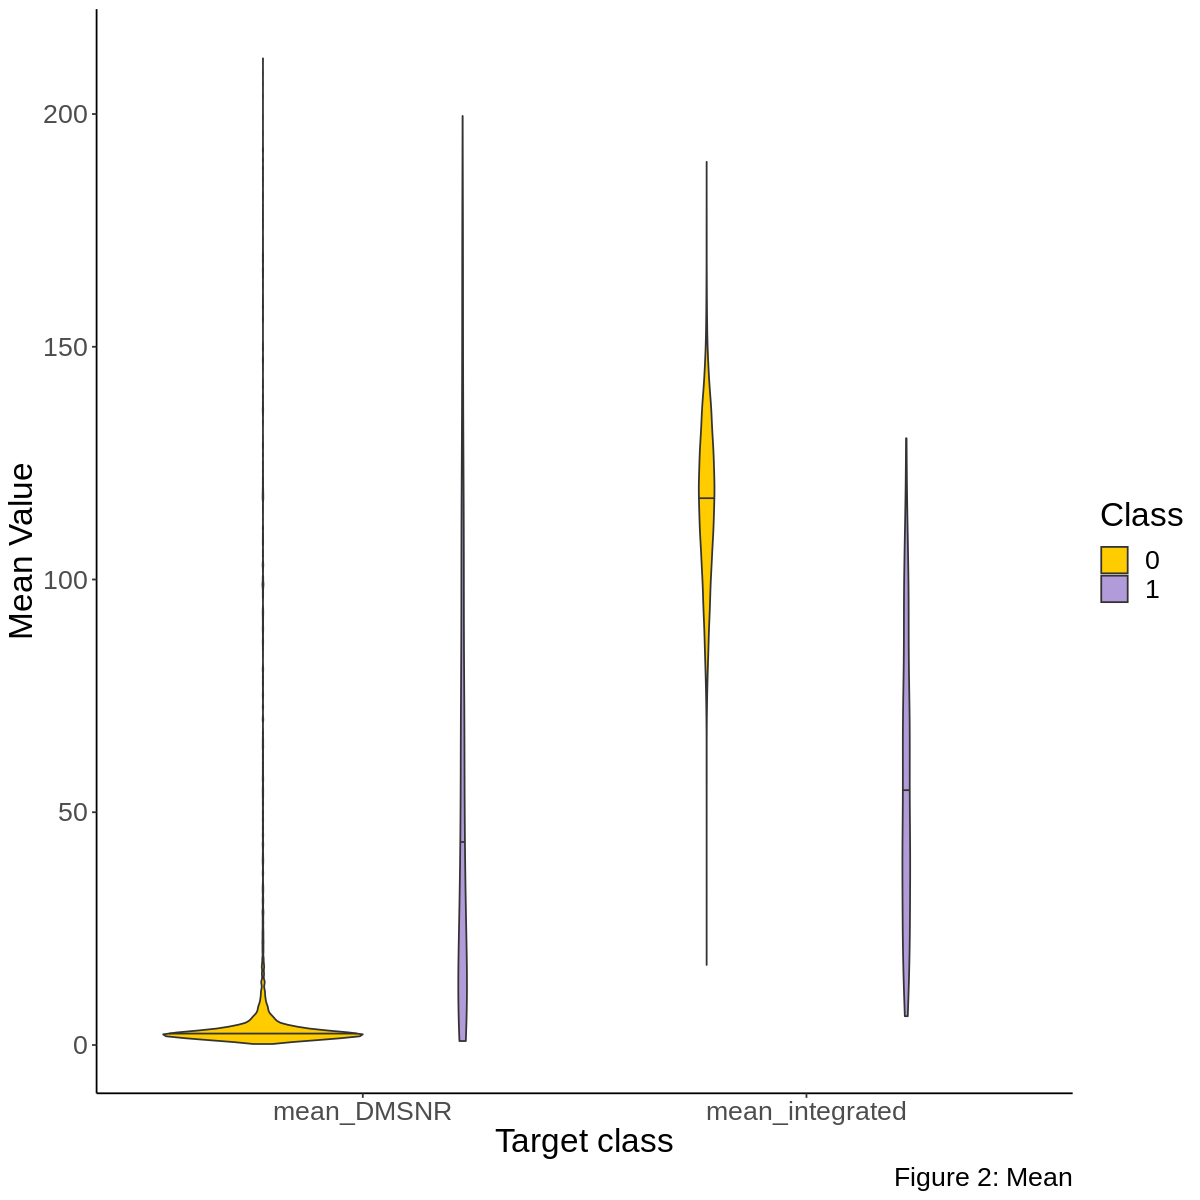

Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


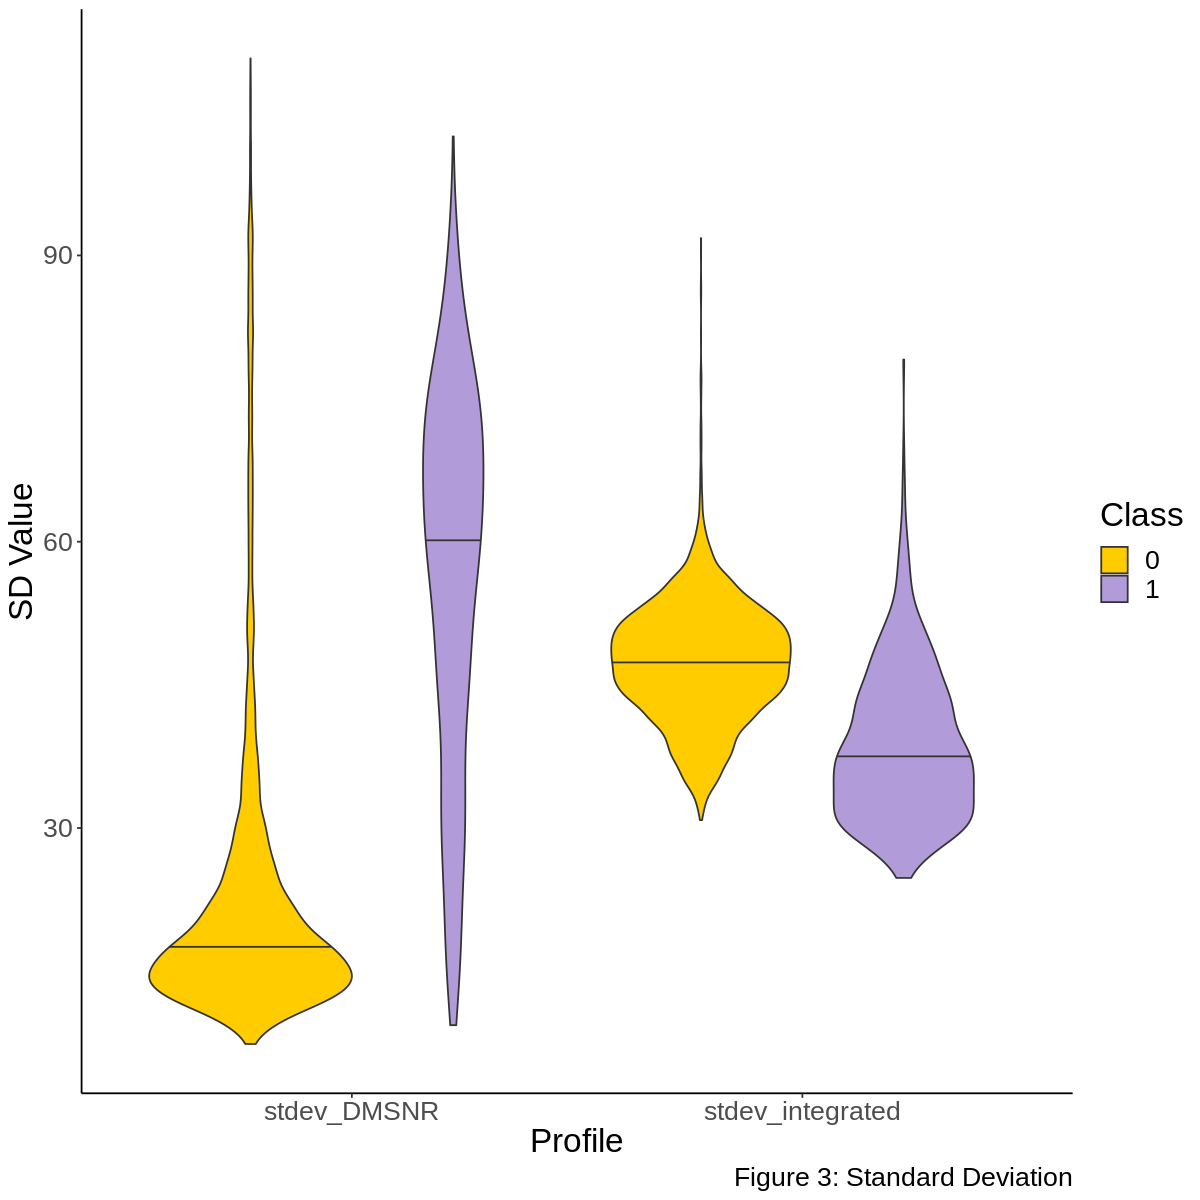

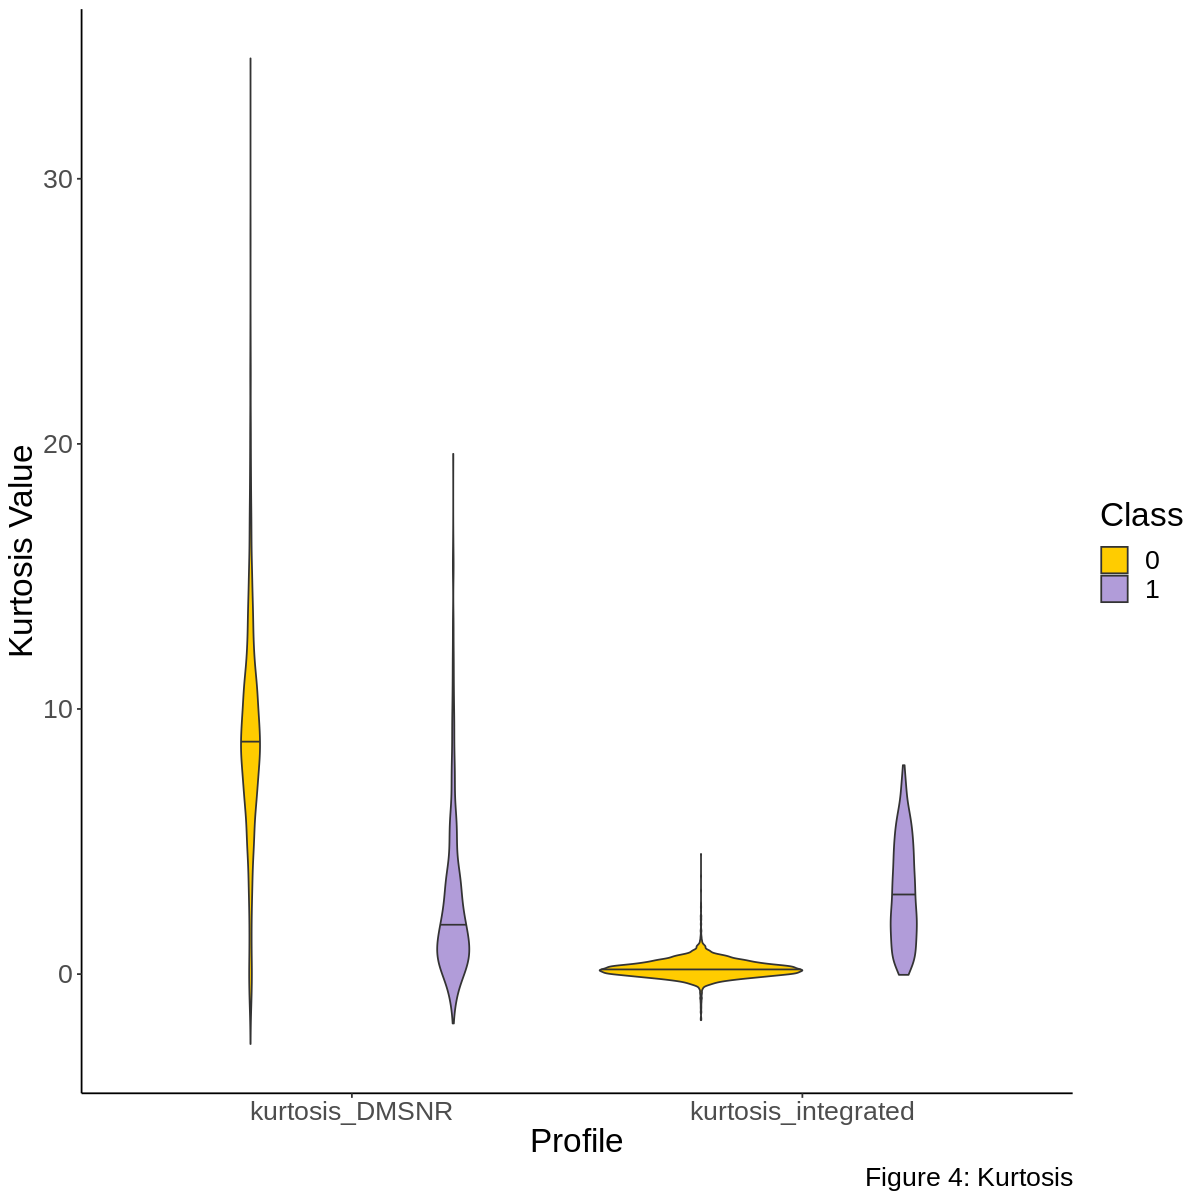

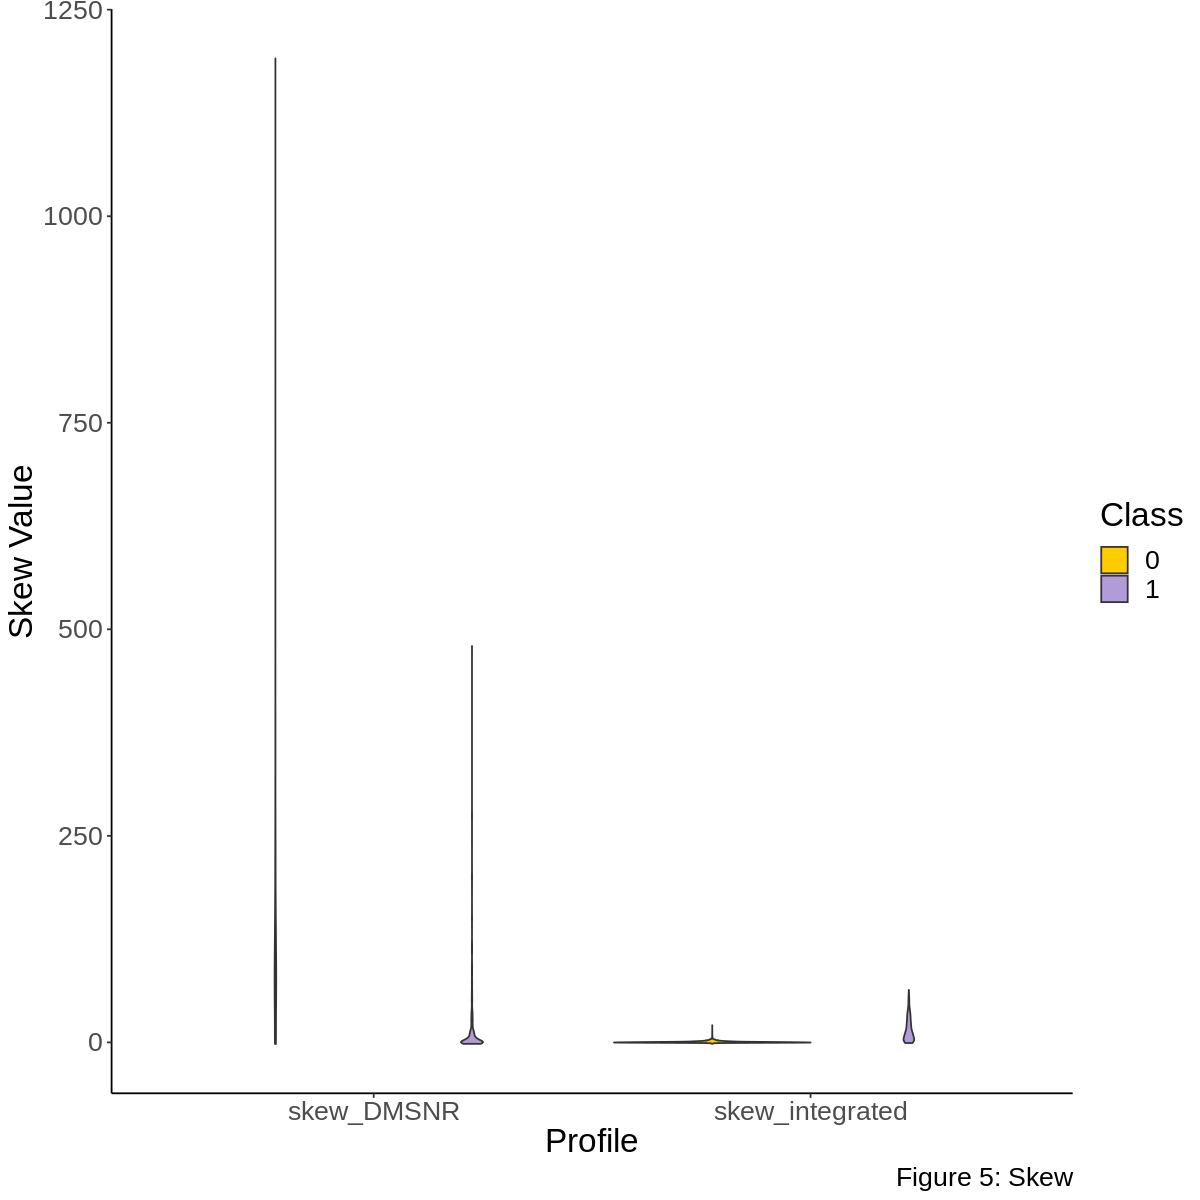

In [ ]:
  options(repr.plot.width= 10, repr.plot.height = 10)
  # make violin plots comparing DM-SNR Curve and Integrated Profile variables, to see how they differ
  # between our target classes
  # tidy the data to generate a profile column

# mean violin
mean_violin <-  tidy_stars %>%
  filter(profile=="mean_integrated"|profile=="mean_DMSNR")%>%
  ggplot(aes(x=profile, y=value), trim=TRUE)+
  geom_violin(aes(fill=class), draw_quantiles=c(0.5))+
  scale_fill_manual(values=c("#FFCC00", "#b19cd9"))+
  xlab("Target class") +
  ylab("Mean Value")+
  labs(fill="Class", caption="Figure 2: Mean")+
  theme_classic()+
  theme(text=element_text(size=20))
mean_violin

# sd violin
  sd_violin <-  tidy_stars %>%
  filter(profile=="stdev_integrated"|profile=="stdev_DMSNR")%>%
  ggplot(aes(x=profile, y=value), trim=TRUE)+
  geom_violin(aes(fill=class), draw_quantiles=c(0.5))+
  scale_fill_manual(values=c("#FFCC00", "#b19cd9"))+
  xlab("Profile") +
  ylab("SD Value")+
  labs(fill="Class", caption="Figure 3: Standard Deviation")+
  theme_classic()+
  theme(text=element_text(size=20))
sd_violin

# kurtosis violin
      kurtosis_violin <-  tidy_stars %>%
  filter(profile=="kurtosis_integrated"|profile=="kurtosis_DMSNR")%>%
ggplot(aes(x=profile, y=value))+
  geom_violin(aes(fill=class), , draw_quantiles=c(0.5))+
  scale_fill_manual(values=c("#FFCC00", "#b19cd9"))+
  xlab("Profile") +
  ylab("Kurtosis Value")+
  labs(fill="Class", caption="Figure 4: Kurtosis")+
  theme_classic()+
  theme(text=element_text(size=20))
kurtosis_violin

# skew_violin
     skew_violin <-  tidy_stars %>%
  filter(profile=="skew_integrated"|profile=="skew_DMSNR")%>%
  ggplot(aes(x=profile, y=value), draw_quantiles=c(0.5))+
  geom_violin(aes(fill=class))+
  scale_fill_manual(values=c("#FFCC00", "#b19cd9"))+
  xlab("Profile") +
  ylab("Skew Value")+
  labs(fill="Class", caption="Figure 5: Skew")+
  theme_classic()+
  theme(text=element_text(size=20))
skew_violin

Figures 2-5 are violin plots of the four types of measurements that were collected (mean, standard deviation, kurtosis, and skew), stratified by target class and profile (integrated vs DMSNR). These plots allow us to determine which predictors will be most useful for building our classification model.

Firstly, it demonstrates how the predictors vary between the two target classes. A predictor whose distribution varies significantly between the target classes (for example, in Figure 3), is likely to be more useful for our classification model than a predictor with very similar distributions.

Secondly, these plots demonstrate the difference between the integrated and DMSNR profiles. We can see which profile varies more between the two target classes, thus allowing us to predict which profile will be more useful for building classification models.

We can see that while each predictor is extremely different depending on whether it is from the integrated or DM-SNR profile, all groups show a difference in the distribution and mean of the target classes within the same variable. So, each would be a useful addition to their respective models. As well, from a broader perspective, we want to use all of the scientific data available to us, since it was painstakingly collected and cleaned, and omission of a particular variable without reasonable grounds could cause us to lose accuracy in our models.

### K-Nearest Neighbors Analysis

After our preliminary analysis, our next step will be to use our integrated and DM-SNR variables to predict pulsar stars using the K-Nearest Neighbors classification algorithm.

This will help us determine whether one of these two recording techniques is better than the other at distinguishing pulsar stars from the noise of space.

Our first step is to set up our KNN model, using the integrated variables. We will do this in several steps.
1. Make a recipe. The recipe will preprocess our data by centering and scaling our predictors (since the ranges of our predictors differ), and upsample our target class (since it is ~90% target class 0).
2. Make a KNN spec, to tell the computer to run KNN (and with what parameters). This will include the neighbors=tune() function so we can find the value of K that gives us the highest accuracy.
3. Make our cross validation sets, so we can test our tuning model and find accuracies of different K's.
4. Make a tuning workflow, to tune the KNN model and find the value of K giving the highest accuracy.

In [ ]:
#1. First, we make our recipe, which will preprocess our data.
recipe_integrated <- recipe(class ~ mean_integrated + stdev_integrated + kurtosis_integrated +
skew_integrated, data = pulsar_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())%>%
    step_upsample(class, over_ratio=1, skip=TRUE)

recipe_integrated

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          4

Operations:

Scaling for all_predictors()
Centering for all_predictors()
Up-sampling based on class

In [ ]:
#2. Next, we will create our model, so the computer knows how to run the KNN
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
            set_engine("kknn") %>%
            set_mode("classification")

In [ ]:
#3. next, we make our cross-validation set to test iterations of K
vfold <- vfold_cv(pulsar_train, v = 5, strata = class)

In [ ]:
#4. now, we make a workflow to find the best value of K, to give our training model the best accuracy.
knn_fit <- workflow() %>%
        add_recipe(recipe_integrated) %>%
        add_model(knn_tune) %>%
        tune_grid(resamples = vfold, grid = 20) %>%
        collect_metrics()
        #note: grid=20 to test 20 values of K, rather than the usual 10
        #This is so we can confidently find the value of K with the highest accuracy by being more rigorous with our testing



Now that our model has been tuned, we can pull the accuracy of our tuning model for each iteration of K, and plot it to show how accuracy changes depending on K.

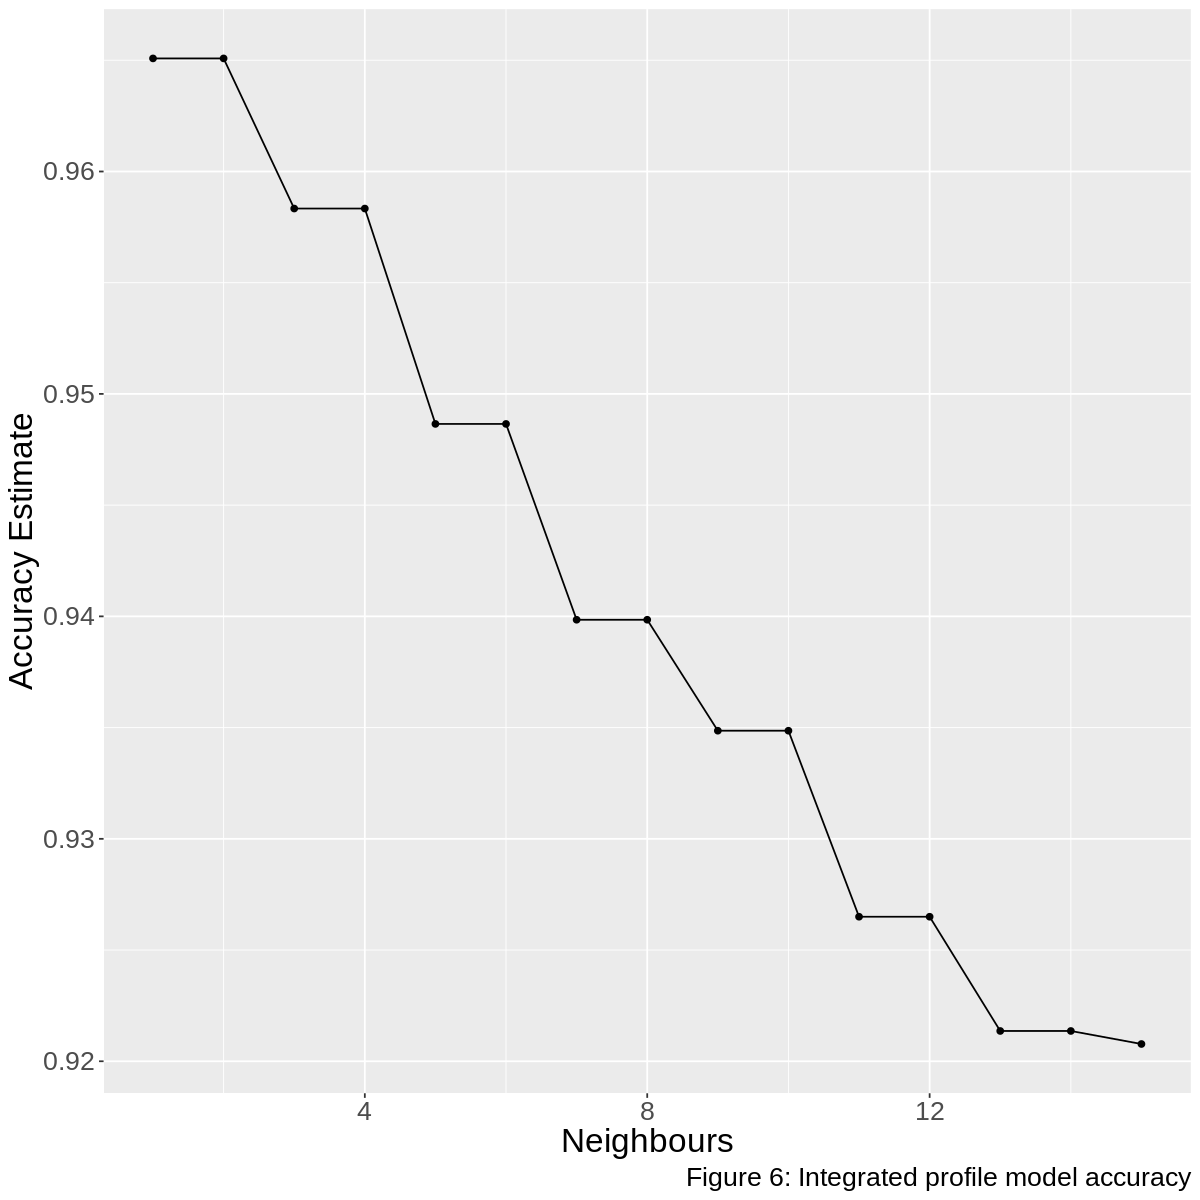

In [ ]:
#pull accuracies
accuracies <- knn_fit %>%
       filter(.metric == "accuracy")
#plot accuracy against K
cross_val_plot <- ggplot(accuracies, aes(x = neighbors , y = mean)) +
       geom_point() +
       geom_line() +
       labs(x = "Neighbours", y = "Accuracy Estimate", caption = "Figure 6: Integrated profile model accuracy")  +
       theme(text = element_text(size = 20))

cross_val_plot

According to the plot above, the value of K that gives the highest accuracy is K=2. We will now make another model that uses this value of K to predict the class of a testing set.
This will require us to make a new KNN spec and workflow- but we can reuse our old recipe, since it isn't affected by choosing K.

In [ ]:
#pull the value of K giving the highest accuracy (2)
kn_integrated <- knn_fit %>%
       filter(.metric == "accuracy") %>%
       arrange(desc(mean)) %>%
       head(1) %>%
       pull(neighbors)
kn_integrated

[1] 1

In [ ]:
#make another KNN spec, this time with neighbors= our chosen value of K
int_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = kn_integrated) %>%
              set_engine("kknn") %>%
              set_mode("classification")
#make the workflow to build our final model
int_fit <- workflow() %>%
             add_recipe(recipe_integrated) %>%
             add_model(int_spec) %>%
             fit(data = pulsar_train)

Now that we've build our final model, we can test it using data it hasn't seen before, i.e. our testing set.
This will tell us its overall accuracy in predicting the class of an unknown star, and how good it is at predicting pulsar stars specifically.
Once we have predicted the testing set, we can gather its metrics to see its accuracy, and plot it as a confusion matrix to see how many times it predicted each class correctly, and incorrectly.

In [ ]:
#predict the testing set using our integrated model
int_pred <- predict(int_fit, pulsar_test) %>%
                    bind_cols(pulsar_test)
#get the accuracy of our model at predicting the test class
int_metrics <- int_pred %>%
metrics(truth = class, estimate=.pred_class)
int_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9643643
kap,binary,0.7990311


Table 5: Integrated profile model metrics



In [ ]:
#make a confusion matrix
int_mat <- int_pred %>%
      conf_mat(truth = class, estimate = .pred_class)
int_mat
tidy_int_mat <- tidy(int_mat) #this is for later

          Truth
Prediction    0    1
         0 2009   40
         1   41  183

Table 6: Confusion matrix for the integrated profile model

We are finished with our integrated model, and can begin making our DM-SNR model.
This will follow the same steps as above. Firstly, we will set up a recipe to tune the value of K to that which gives the highest accuracy of our training model.
To do this, we will:
1. Make a new recipe.
2. Reuse our old KNN spec (since it doesn't depend on our variables)
3. Reuse our old cross validation sets (since they don't depend on our variables)
4. Make a tuning workflow, to find the best value of K.


In [ ]:
#make the recipe
recipe_DMSNR <- recipe(class ~ mean_DMSNR + stdev_DMSNR + kurtosis_DMSNR +
skew_DMSNR, data = pulsar_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())%>%
    step_upsample(class, over_ratio=1, skip=TRUE)

recipe_DMSNR

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          4

Operations:

Scaling for all_predictors()
Centering for all_predictors()
Up-sampling based on class

In [ ]:
#reuse KNN spec and cross validation sets
#make our tuning workflow
knn_fit <- workflow() %>%
        add_recipe(recipe_DMSNR) %>%
        add_model(knn_tune) %>%
        tune_grid(resamples = vfold, grid = 20) %>% #note: grid=20 to test 20 values of K, rather than the usual 10
        collect_metrics()



With our DM-SNR tuning workflow, we can pull the accuracies of each K in our tuning model, and plot them to see how accuracy depends on K.

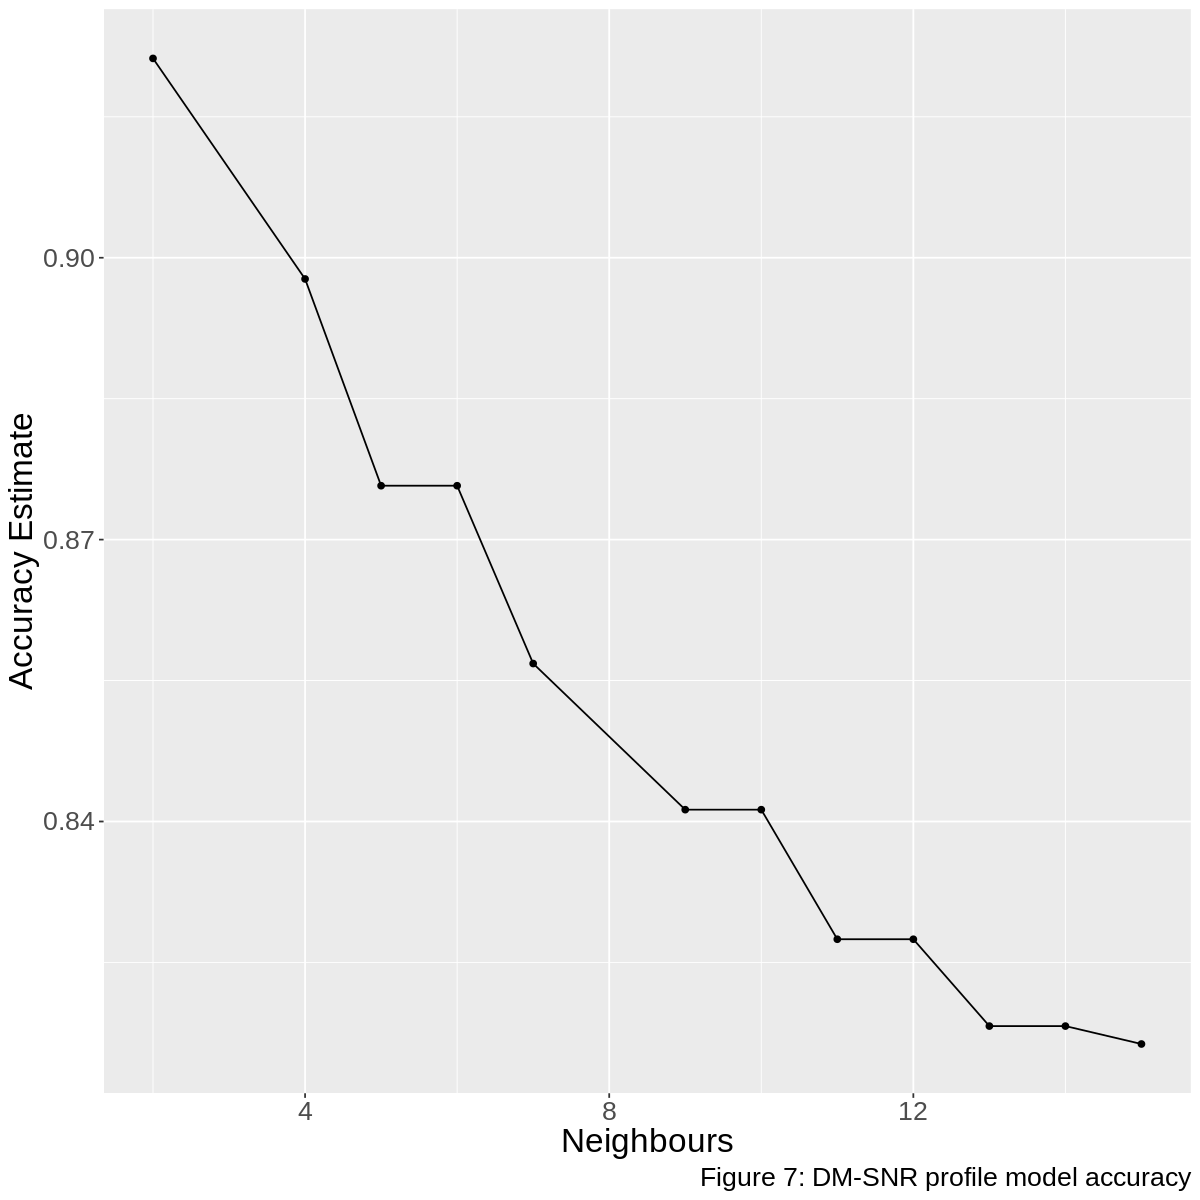

In [ ]:
#pull accuracies
accuracies <- knn_fit %>%
       filter(.metric == "accuracy")
#make the plot
cross_val_plot <- ggplot(accuracies, aes(x = neighbors , y = mean)) +
       geom_point() +
       geom_line() +
       labs(x = "Neighbours", y = "Accuracy Estimate", caption = "Figure 7: DM-SNR profile model accuracy")  +
       theme(text = element_text(size = 20))

cross_val_plot

The plot tells that the value of K giving the highest accuracy of our training model is K=1. We will pull that value, and use it to build a new model to predict our testing set (and other unknown stars). We can reuse our old recipe and build a new KNN spec for our best value of K (value of K giving the highest accuracy), and a new workflow for our final DM-SNR model.

In [ ]:
#get best value of K
kn_DMSNR <- knn_fit %>%
       filter(.metric == "accuracy") %>%
       arrange(desc(mean)) %>%
       head(1) %>%
       pull(neighbors)
kn_DMSNR

[1] 2

In [ ]:
#make new KNN spec with best value of K
DMSNR_int_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = kn_DMSNR) %>%
              set_engine("kknn") %>%
              set_mode("classification")
#make final workflow
DMSNR_int_fit <- workflow() %>%
             add_recipe(recipe_DMSNR) %>%
             add_model(DMSNR_int_spec) %>%
             fit(data = pulsar_train)

Now that our final DM-SNR model is built, we will test it on data it hasn't seen before (the testing set) to find its accuracy. We can pull the overall accuracy of the model using the metrics() function, and use a confusion matrix to show how many times our model correctly and incorrectly identified the class of the stars by comparing their true and predicted class.

In [ ]:
#Predict the testing data
DMSNR_int_pred <- predict(DMSNR_int_fit, pulsar_test) %>%
                    bind_cols(pulsar_test)
#get the accuracy of our model at predicting the classes of the test data
DMSNR_int_metrics <- DMSNR_int_pred %>%
metrics(truth = class, estimate=.pred_class)
DMSNR_int_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9150902
kap,binary,0.5211483


Table 7: DM-SNR model metrics

In [ ]:
#make a confusion matrix
DMSNR_mat <- DMSNR_int_pred %>%
      conf_mat(truth = class, estimate = .pred_class)
DMSNR_mat
tidy_DMSNR_mat <- tidy(DMSNR_mat)#this is for later

          Truth
Prediction    0    1
         0 1953   96
         1   97  127

Table 8: DM-SNR model confusion matrix

Finally, to display our data we will make a grouped bar chart, showing both the overall accuracy and the accuracy of predicting pulsar stars (the true positive rate).
It is important for us to look at overall accuracy and pulsar star classification accuracy because while we do want a model that has a high overall accuracy, our goal is to find the model that is the best at predicting pular stars (not just non-pulsars), so we need to compare both metrics of our models. We will also calculate a false positive rate, as the goal of our project is to correctly identify pulsar stars - so while a false negative (classifying a pulsar as a non-pulsar star) is not ideal, it is not as detrimental as false positives (classifying a non-pulsar as a pulsar) as this affects our ability to gain accurate knowledge on pulsar stars using our model.

In [ ]:
#gather the values from our accuracy estimates
#gather overall accuracy estimates from our two models
DMSNR_accuracy <- as.numeric(DMSNR_int_metrics[1, 3])*100 #92.3%
integrated_accuracy <- as.numeric(int_metrics[1, 3])*100 #96.8%

#gather accuracy estimates of pulsar stars only from our confusian matrices
#this is correctly identified pulsars/ total number of true pulsars *100
pulsar_integrated <- as.numeric(tidy_int_mat[4,2])/
(as.numeric(tidy_int_mat[3,2])+as.numeric(tidy_int_mat[4,2]))*100
pulsar_integrated #77.5%
pulsar_DMSNR <- as.numeric(tidy_DMSNR_mat[4,2])/
(as.numeric(tidy_DMSNR_mat[3,2])+as.numeric(tidy_DMSNR_mat[4,2]))*100
pulsar_DMSNR #58.0%

#gather accuracy estimates of pulsar stars from confusion matrix
#calculate false positive rate
#this is false positive rate (0's classified as 1)/total negatives (all 0's) *100
integrated_falsepos <- as.numeric(tidy_int_mat[2, 2])/
(as.numeric(tidy_int_mat[1, 2])+as.numeric(tidy_int_mat[2, 2]))*100
integrated_falsepos #1.2%
DMSNR_falsepos <- as.numeric(tidy_DMSNR_mat[2,2])/
((as.numeric(tidy_DMSNR_mat[1,2])+as.numeric(tidy_DMSNR_mat[2,2])))*100
DMSNR_falsepos #4.2%

[1] 82.06278

[1] 56.95067

[1] 2

[1] 4.731707

Now we can plot our accuracy estimates as a grouped bar chart.

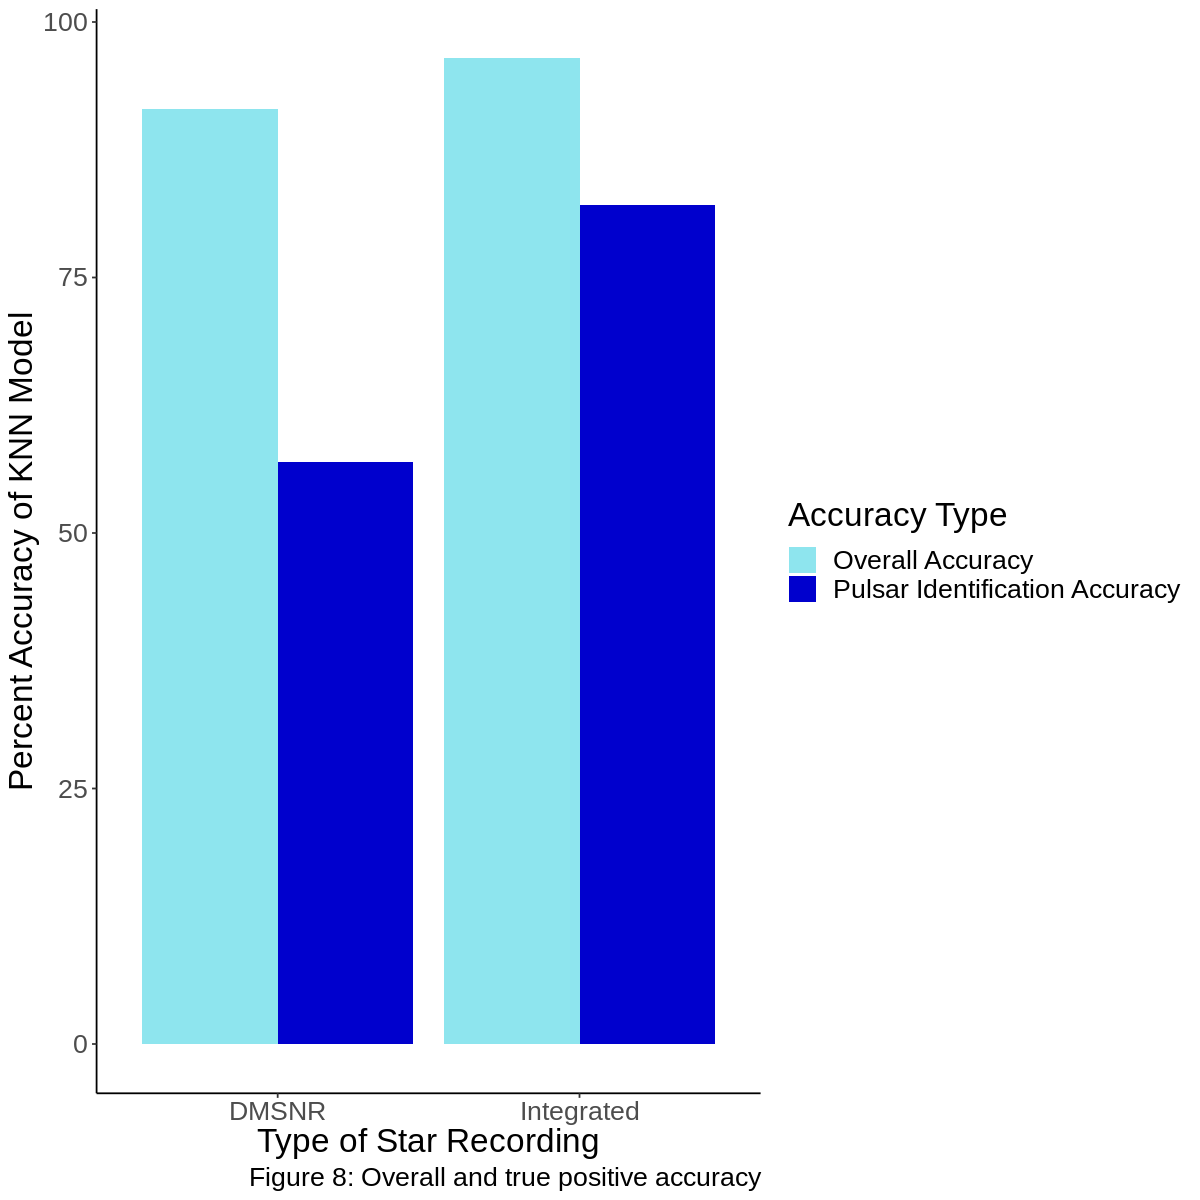

In [ ]:
#make a new dataframe for our plot
accuracies <- data.frame("percent_accuracy"=c(DMSNR_accuracy, integrated_accuracy, pulsar_integrated, pulsar_DMSNR))
names <- data.frame("type"=c("DMSNR", "Integrated", "Integrated", "DMSNR"))
subgroup <- data.frame("subgroup"=c("Overall Accuracy", "Overall Accuracy", "Pulsar Identification Accuracy", "Pulsar Identification Accuracy"))
accuracy_table <- bind_cols(names, accuracies, subgroup)

#make the plot
accuracy_plot <- ggplot(accuracy_table, aes(x=type, y=percent_accuracy, fill=subgroup))+
geom_bar(aes(fill=subgroup),stat="identity", position="dodge")+
  scale_fill_manual(values=c("cadetblue2", "blue3" ))+
  labs(x="Type of Star Recording", y="Percent Accuracy of KNN Model", fill="Accuracy Type", caption="Figure 8: Overall and true positive accuracy")+
  theme_classic()+
theme(text = element_text(size=20))
  accuracy_plot



From this barchart, we observe that the overall accuracy and accuracy of pulsar star identification differs between our two models. In both, the integrated model shows higher accuracy.

## Discussion

We created two models using the provided metrics for the integrated and DM-SNR profiles. The first model using integrated profile predictors yielded an accuracy of 96% for all predicted classes. The second model using the DM-SNR curve predictors had a lower accuracy at 91% for all predicted classes. In addition to better overall accuracy, the integrated curve model was also more accurate when predicting true positives (i.e. correctly identifying pulsar stars). Out of 219 pulsar stars in our data set, the integrated curve model correctly identified 178 (78%), compared with the DM-SNR curve model which only identified 127 (58%). Clearly, the integrated model is better than the DM-SNR curve model at predicting pulsar stars from the noise of space. However, considering how rare pulsar stars are an 81% accuracy of our best model may not be good enough if it is to be used in scientific research. To elucidate this, we calculated a false positive rate for each model, as falsely identifying a non-pulsar as a pulsar star affects the quality of future research far more than missing a pulsar star due to a false negative. Our integrated model had a false positive rate of 1.2%, while our DM-SNR model had a false positive rate of 4.2%. So again we see our integrated model is better at distinguishing pulsar stars, would give better prediction accuracy for our key metrics, and is a better choice for use in classifying new stars.

By predicting the target class for each observation in the testing data set using the integrated model, we accurately differentiated pulsars from non-pulsars for each observation in the testing data set and could predict the class of recently recorded pulsar observations.

Contrary to our hypothesis that the DM-SNR curve model would be more accurate, the integrated profile model proved to be better at predicting pulsars. The reasoning for our hypothesis was that the DM-SNR curve would be a better preprocessing method which removed distortions in pulse shapes due to dispersion, in comparison to the integrated pulse profile which preprocessed the time series by folding the data with respect to the rotational period.
Analyzing the integrated vs DM-SNR model's accuracies tells us how well these recording methods can identify a pulsar star and the best variables for filtering pulsar stars from the noise of space. We used the integrated model to predict the target class for the observations in the testing dataset, differentiating pulsar stars from non-pulsars. Prediction of pulsars will be beneficial for scientists and astronomers for celestial research. Using pulsar stars, scientists can measure cosmic distances, time and search for planets beyond Earth's solar system. Moreover, it is possible to measure how the presence of massive bodies curves space-time. By observing pulsars, the researchers have shown repeatedly that close double neutron star systems send out strong gravitational waves (Cofield 2016). Helping scientists efficiently and accurately identify pulsar stars will ultimately help advance research areas that depend on pulsar stars.

Now that we have demonstrated a reasonably effective model using the provided data set, the next step would be to test our model out in the real world. This will give us a better idea of how useful our model might actually be to scientists interested in identifying pulsar stars, as the competition data set we used for our model may not be entirely representative of the data typically produced by radio telescopes. We may find that additional cleaning or wrangling is needed in order to deploy our model on real-world data.

At the end of the data analysis, several questions may arise:
- Are either of our models accurate enough for scientific research?
- Is another classification model better suited to this data (e.g. Random Forest)?
- Which predictors need more scientific advancement until they are as useful as the others?
- Our best values of K were quite low. Do we need to omit variables that are adding extra variation into our models?
- How accurate are the predicted labels from the model?
- Can we further improve the model or method of classification?

## Works cited

Cofield,C.(2016, April 22). What Are Pulsars? .  https://www.space.com/32661-pulsars.html

Grootjans et al. (2016, August). Detection of Dispersed Pulsars in a Time Series by Using a Matched Filtering Approach. https://essay.utwente.nl/71435/1/GROOTJANS_MA_EWI.pdf

Goldberger, A. (2019, January 04). Classifying pulsar stars using AI techniques. https://medium.com/duke-ai-society-blog/classifying-pulsar-stars-using-ai-techniques-d2be70c0f691

Max Planck Institute, PULSE: The Impact of European Pulsar Science on Modern Physics, https://phys.org/news/2005-12-pulse-impact-european-pulsar-science.html#:~:text=By%20observing%20pulsars%2C%20the%20researchers,confirm%20Einstein's%20General%20Relativity%20Theory.

(n.d.). Ggplot2 violin plot : Quick start guide - R software and data visualization. STHDA. http://www.sthda.com/english/wiki/ggplot2-violin-plot-quick-start-guide-r-software-and-data-visualization

(n.d.). Violin Plot. Ggplot 2. https://ggplot2.tidyverse.org/reference/geom_violin.html

Rodriguez, F. (2019, October 07). Pulsar Stars Detection. https://datauab.github.io/pulsar_stars/

Liu K., (2017, June 26).Introduction to Pulsar, Pulsar Timing, and
measuring of Pulse Time-of-Arrivals. http://ipta.phys.wvu.edu/files/student-week-2017/IPTA2017_KuoLiu_pulsartiming.pdf